---

**<h1><center>Análisis de la calidad de trozos de caña de azúcar mediante visión artificial</center></h1>**

**<h2><center> Visión Artificial - 2024-2</center></h2>**

<center><img src="unal.png" width="300"></center>

**<h3> Presentado por: </h3>**
<ul>
  <li>Juan Esteban Arango Zapata - <a href="mailto:juarangoz@unal.edu.co">juarangoz@unal.edu.co</a> - CC 1018230863</li>
  <li>Paulina Hernández Morales - <a href="mailto:pauhernandezmo@unal.edu.co">pauhernandezmo@unal.edu.co</a> - TI 1035420888</li>
  <li>Jimena Hernández Castillo - <a href="mailto:jihernandezc@unal.edu.co">jihernandezc@unal.edu.co</a> - TI 1022094340</li>
  <li>Juan Camilo López López - <a href="mailto:julopezlop@unal.edu.co">julopezlop@unal.edu.co</a> - CC 1025533050</li>
</ul>

---

**<h3><center> Extracción de características </h3></center>**

**<h4>Importación de librerias:</h4>**

In [40]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

**<h4>Detector de puntos clave:</h4>**

Los detectores clásicos no siempre funcionan bien con trozos de caña, así que hicimos `CustomKeypointDetector`, que encuentra puntos clave con un método mejorado basado en Harris, y saca descriptores combinando gradientes, intensidad y patrones locales.  

In [41]:
class CustomKeypointDetector:
    def __init__(self):
        self.patch_size = 16  # Tamaño de la región alrededor del punto clave
        self.threshold = 0.01  # Umbral para detección de puntos
        
    def detect_keypoints(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        
        # 1. Detectar esquinas usando una versión modificada del método de Harris
        dx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        dy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        
        Ixx = gaussian_filter(dx**2, sigma=2)
        Iyy = gaussian_filter(dy**2, sigma=2)
        Ixy = gaussian_filter(dx*dy, sigma=2)
        
        # Calcular la respuesta de Harris
        det = Ixx * Iyy - Ixy**2
        trace = Ixx + Iyy
        response = det - 0.05 * (trace**2)
        
        # Encontrar máximos locales
        keypoints = []
        pad = self.patch_size // 2
        
        for y in range(pad, gray.shape[0] - pad):
            for x in range(pad, gray.shape[1] - pad):
                if response[y, x] > self.threshold:
                    # Verificar si es máximo local en una ventana 3x3
                    window = response[y-1:y+2, x-1:x+2]
                    if response[y, x] == np.max(window):
                        keypoints.append((x, y))
        
        return keypoints
    
    def compute_descriptors(self, image, keypoints):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptors = []
        
        for x, y in keypoints:
            # Extraer parche alrededor del punto clave
            patch = gray[y-self.patch_size//2:y+self.patch_size//2,
                        x-self.patch_size//2:x+self.patch_size//2]
            
            # 1. Gradientes
            dx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)
            dy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)
            
            # Magnitud y orientación de gradientes
            magnitude = np.sqrt(dx**2 + dy**2)
            orientation = np.arctan2(dy, dx)
            
            # 2. Histograma de gradientes
            hist_grad = np.histogram(orientation.flatten(), bins=8, 
                                   weights=magnitude.flatten(), range=(-np.pi, np.pi))[0]
            
            # 3. Estadísticas locales
            mean_intensity = np.mean(patch)
            std_intensity = np.std(patch)
            
            # 4. Patrones de intensidad
            threshold = np.mean(patch)
            binary_pattern = (patch > threshold).astype(np.float32)
            pattern_features = np.mean(binary_pattern, axis=1)  # Promedio por filas
            
            # Combinar todas las características en un descriptor
            descriptor = np.concatenate([
                hist_grad / np.sum(hist_grad),  # Normalizado
                [mean_intensity / 255, std_intensity / 255],  # Normalizados
                pattern_features
            ])
            
            descriptors.append(descriptor)
            
        return np.array(descriptors)

**<h4>Procesador de las imágenes:</h4>**

La función `process_sugarcane_images(image_paths)` se encarga de recorrer una lista de imágenes, cargarlas y verificar que se puedan leer. Luego, usa el detector creado anteriormente para encontrar puntos clave y extraer descriptores en cada imagen. Toda esta información se guarda en un diccionario, incluyendo la imagen original, los puntos clave detectados y sus descriptores. Al final, imprime un pequeño resumen con el número de puntos clave encontrados y la dimensión de los descriptores, para obtener una visión general de la textura y estructura de los trozos de caña.


In [42]:
def process_sugarcane_images(image_paths):
    detector = CustomKeypointDetector()
    results = {}
    
    for path in image_paths:
        image = cv2.imread(path)
        if image is None:
            print(f"No se pudo leer la imagen: {path}")
            continue
            
        keypoints = detector.detect_keypoints(image)
        descriptors = detector.compute_descriptors(image, keypoints)
        
        results[path] = {
            'image': image,
            'keypoints': keypoints,
            'descriptors': descriptors,
            'num_keypoints': len(keypoints)
        }
        
        print(f"\nResultados para {path}:")
        print(f"Número de puntos clave encontrados: {len(keypoints)}")
        print(f"Dimensión de los descriptores: {descriptors.shape if descriptors is not None else 'N/A'}")
        
    return results

**<h4>Mapas de densidad:</h4>**

En lugar de mostrar los puntos clave de forma individual, esta función crea mapas de densidad para cada imagen. Para ello, `visualize_density_map(results)` toma los resultados del análisis y genera una representación visual donde las zonas con mayor concentración de puntos clave aparecen resaltadas.  

Primero, se inicializa una figura con varias subgráficas para mostrar múltiples imágenes. Luego, para cada imagen, se construye un mapa de densidad a partir de los puntos clave detectados, difuminándolo con un filtro gaussiano para suavizar la distribución. Finalmente, el mapa se superpone a la imagen original con una escala de color para resaltar las regiones más densas. Así, obtenemos una representación más intuitiva de la estructura y patrones dentro de los trozos de caña.


In [43]:
def visualize_density_map(results):
    num_images = len(results)
    rows = (num_images + 2) // 3  

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows)) 
    axes = axes.flatten()  # Aplana la matriz de ejes para facilitar el acceso

    for i, (path, data) in enumerate(results.items()):
        image = data['image']
        keypoints = data['keypoints']

        h, w = image.shape[:2]
        density_map = np.zeros((h, w))  # Inicializa el mapa de densidad

        for x, y in keypoints:
            x, y = int(x), int(y)
            if 0 <= x < w and 0 <= y < h:
                density_map[y, x] += 1  # Incrementa el valor en la posición del punto clave

        density_map = gaussian_filter(density_map, sigma=10)  # Aplica un filtro gaussiano para suavizar el mapa

        if np.max(density_map) > 0:
            density_map /= np.max(density_map)  # Normaliza el mapa de densidad

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convierte la imagen a RGB
        axes[i].imshow(image_rgb)  # Muestra la imagen original
        axes[i].imshow(density_map, alpha=0.5, cmap='hot')  # Superpone el mapa de densidad
        axes[i].axis('off')  # Oculta los ejes

    for j in range(i+1, len(axes)):
        axes[j].axis('off')  # Oculta los ejes de los subplots vacíos
        axes[j].set_visible(False)  # Oculta los subplots vacíos

    plt.tight_layout()  
    return fig  

**<h4>Mapas de distribución:</h4>**

Esta función se encarga de crear mapas de calor para visualizar cómo se distribuyen los puntos clave en diferentes imágenes, organizándolos por categoría. Primero, identifica la categoría de cada imagen a partir de su nombre y agrupa los datos. Luego, toma una muestra de hasta 10,000 puntos clave por imagen para no sobrecargar el proceso y normaliza sus coordenadas para ajustarlas a una escala común. Después, genera un heatmap aplicando un filtro gaussiano que suaviza la densidad y usa un esquema de colores personalizado para destacar las zonas con mayor concentración de puntos. 


In [44]:
def create_distribution_visualization(results):
    categories = set()
    for path in results.keys():
        category = os.path.basename(path).split('_')[0]
        categories.add(category)  # Extrae y agrega la categoría de cada imagen
    
    num_categories = len(categories)
    
    fig, axes = plt.subplots(1, num_categories, figsize=(6*num_categories, 6))  # Crea una figura con subplots
    if num_categories == 1:
        axes = [axes]  # Asegura que axes sea una lista si hay solo una categoría
    
    categories_data = {}
    for path, data in results.items():
        category = os.path.basename(path).split('_')[0]
        categories_data.setdefault(category, []).append(data)  # Agrupa los datos por categoría
    
    for i, (category, category_data) in enumerate(sorted(categories_data.items())):
        resolution = 300
        heatmap = np.zeros((resolution, resolution))  # Inicializa el heatmap
        
        total_points = 0
        
        for data in category_data:
            image = data['image']
            keypoints = data['keypoints']
            
            sampled_keypoints = random.sample(keypoints, min(len(keypoints), 10000))  # Muestra aleatoria de puntos clave
            
            h, w = image.shape[:2]
            for x, y in sampled_keypoints:
                x_norm = int(x * resolution / w)
                y_norm = int(y * resolution / h)
                
                if 0 <= x_norm < resolution and 0 <= y_norm < resolution:
                    heatmap[y_norm, x_norm] += 1
                    total_points += 1  # Incrementa el contador de puntos totales
        
        heatmap = gaussian_filter(heatmap, sigma=5)  # Aplica un filtro gaussiano para suavizar el heatmap
        
        if total_points > 0:
            heatmap /= np.max(heatmap)  # Normaliza el heatmap
        
        colors = [(0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 0), (1, 0, 0)]
        cmap_name = f'custom_{category}'
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)  # Crea un colormap personalizado
        
        im = axes[i].imshow(heatmap, cmap=cm)  # Muestra el heatmap
        axes[i].set_title(f'Distribución de puntos - {category}') 
        axes[i].axis('off')  
        
        cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)  
        cbar.set_label('Densidad normalizada') 
    
    plt.tight_layout() 
    return fig  

**<h4>Ejecución del procesamiento y visualización:</h4>**

Cargamos las imágenes que segmentamos en el notebook anterior y ejecutamos el análisis de características. 


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_28592\376399117.py:68: RuntimeWarning: invalid value encountered in divide
  hist_grad / np.sum(hist_grad),  # Normalizado



Resultados para segmentation_applied\Damaged_KMeans_applied.png:
Número de puntos clave encontrados: 2628
Dimensión de los descriptores: (2628, 26)

Resultados para segmentation_applied\Healthy_KMeans_applied.png:
Número de puntos clave encontrados: 2265
Dimensión de los descriptores: (2265, 26)

Resultados para segmentation_applied\Mutilated_KMeans_applied.png:
Número de puntos clave encontrados: 3329
Dimensión de los descriptores: (3329, 26)


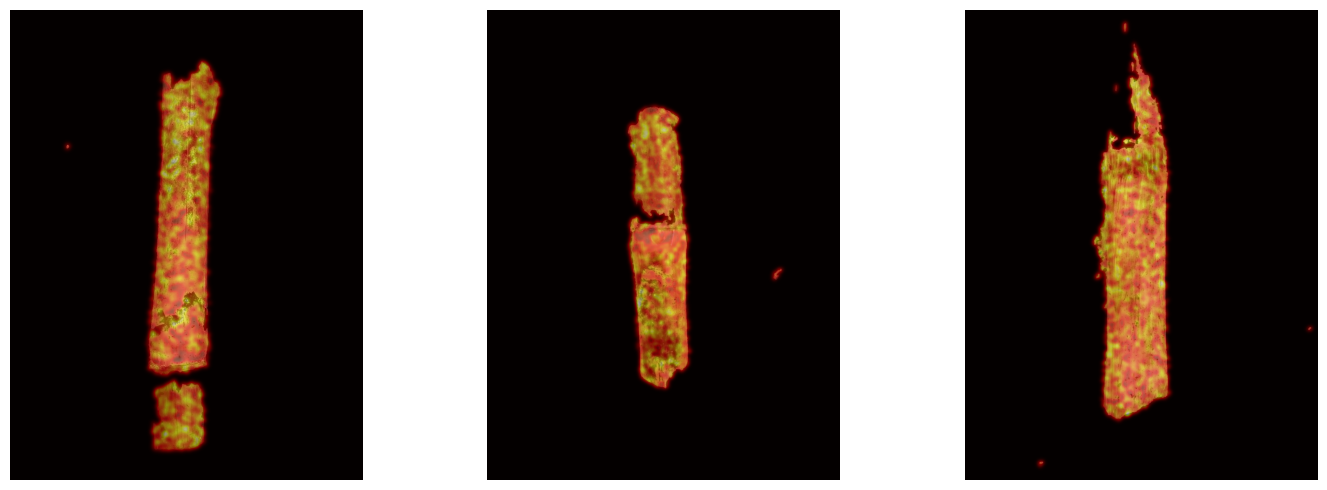

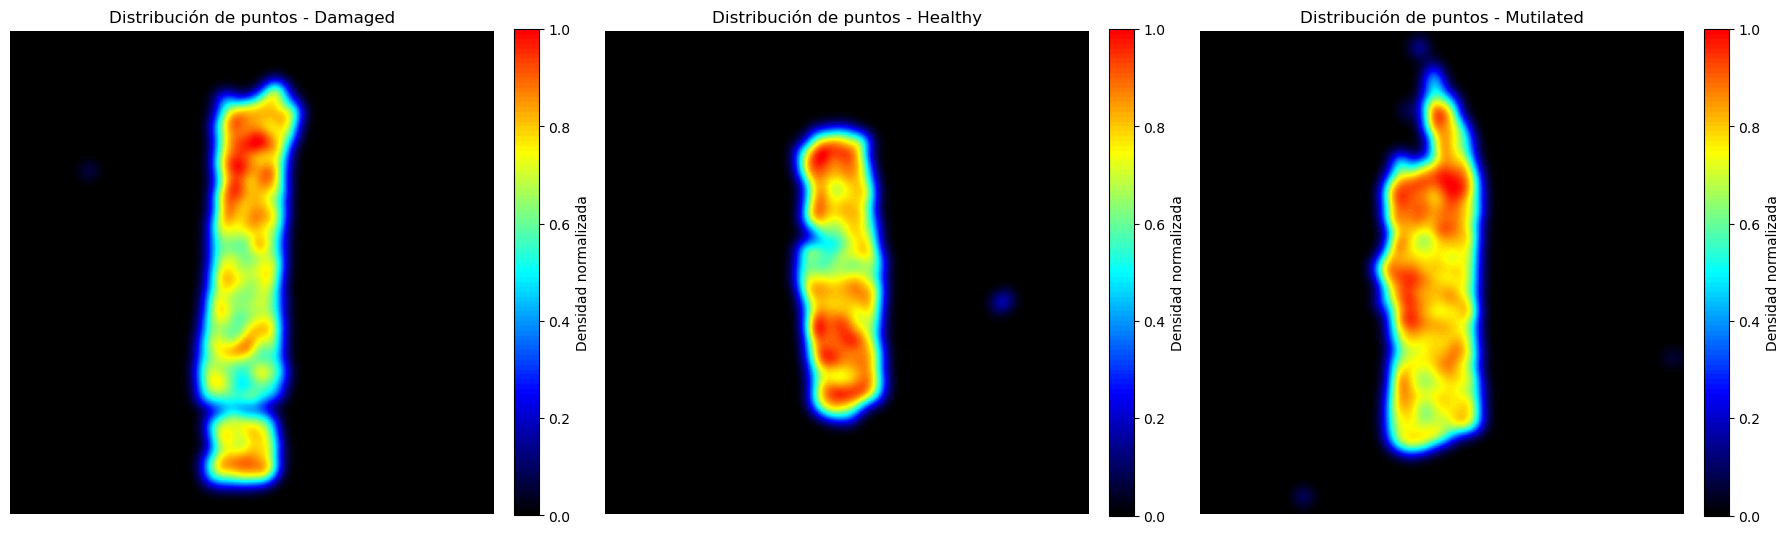

In [45]:
directorio = "segmentation_applied"
image_paths = [os.path.join(directorio, archivo) for archivo in os.listdir(directorio) if archivo.endswith((".png", ".jpg", ".jpeg"))]

results = process_sugarcane_images(image_paths)

density_map_fig = visualize_density_map(results)
distribution_fig = create_distribution_visualization(results)

plt.show()

De los resultados obtenidos anteriormente, destacamos que la muestra Mutilated  tiene el mayor número de puntos clave, lo que podría indicar una mayor complejidad en los patrones detectados debido a la irregularidad y daños presentes. En contraste, la muestra Healthy tiene la menor cantidad de puntos clave, lo que sugiere una estructura más uniforme y menos texturizada.

**Distribución de densidad en los mapas de calor:**

En los mapas de calor, se observa que las áreas con mayor concentración de puntos clave están representadas en tonos rojos y amarillos.
- Damaged presenta una distribución uniforme de puntos clave a lo largo de la muestra, con mayor densidad en ciertas zonas centrales y los extremos.
- Healthy presenta una densidad de puntos clave más dispersa, lo que sugiere una superficie más homogénea y menos afectada por daños.
- Mutilated presenta una distribución más heterogénea con zonas de alta densidad, especialmente en las áreas donde la caña parece rota o con bordes irregulares.

**<h4>Características GLCM:</h4>**

La Matriz de Co-ocurrencia de Niveles de Gris (GLCM) es una técnica utilizada para analizar la textura de una imagen midiendo cómo varían los niveles de gris entre píxeles vecinos. En este contexto, la usamos para cuantificar diferencias en la estructura de la caña de azúcar y así distinguir entre muestras sanas, dañadas y mutiladas. Extraemos seis descriptores clave (dissimilarity, contrast, homogeneity, ASM, energy y correlation), los cuales nos ayudan a entender patrones de irregularidad, uniformidad y contraste en cada imagen.


In [46]:
def get_glcm_features(img):
    features = {}
    glcm = graycomatrix(img, [1, 2, 3], [0], 256, symmetric=True, normed=True)
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
    features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    features['ASM'] = graycoprops(glcm, 'ASM')[0, 0]
    features['energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    return features

def process_images(folder):
    data = []
    for filename in os.listdir(folder):
        if "KMeans" in filename and filename.endswith(".png"):
            file_path = os.path.join(folder, filename)
            img = imread(file_path)
            if len(img.shape) == 3:
                img_gray = rgb2gray(img)
            else:
                img_gray = img
            features = get_glcm_features((img_gray * 255).astype(np.uint8))
            
            # Identificar el tipo de caña
            if "damaged" in filename.lower():
                category = "damaged"
            elif "healthy" in filename.lower():
                category = "healthy"
            elif "mutilated" in filename.lower():
                category = "mutilated"
            else:
                continue
            
            features['category'] = category
            features['filename'] = filename
            data.append(features)
    
    return pd.DataFrame(data)

# Carpeta de imágenes
folder_path = "segmentation_cleaned"
df = process_images(folder_path)

# Mostrar las primeras filas del dataframe
print(df.head())

   dissimilarity  contrast  homogeneity       ASM    energy  correlation  \
0       0.001314  0.001314     0.999343  0.803771  0.896533     0.993257   
1       0.000845  0.000845     0.999577  0.860206  0.927473     0.993918   
2       0.001204  0.001204     0.999398  0.805844  0.897688     0.993760   

    category                      filename  
0    damaged    Damaged_KMeans_cleaned.png  
1    healthy    Healthy_KMeans_cleaned.png  
2  mutilated  Mutilated_KMeans_cleaned.png  


Los resultados de GLCM refuerzan lo que ya habíamos notado en los análisis anteriores: las muestras con más daño tienden a mostrar mayor variabilidad en su textura. En particular, Damaged presenta los valores más altos de dissimilarity y contrast, lo que indica una distribución menos uniforme de los niveles de gris. En cambio, Healthy tiene la mayor homogeneity y ASM, lo que confirma que su textura es más regular y uniforme.

Un punto interesante es que, aunque la muestra Mutilated tenía la mayor cantidad de puntos clave en el análisis previo, aquí sus valores de textura no son tan extremos como los de Damaged. Esto sugiere que, aunque su estructura es más caótica, la variación en los niveles de gris no es tan marcada.